# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

[T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 2





In [1]:
# load standard set of Python modules
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import sys
if sys.version_info < (3,):
    try:
        from builtins import (bytes, dict, int, list, object, range, str,
                              ascii, chr, hex, input, next, oct, open,
                              pow, round, super, filter, map, zip)
        from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                              file, long, raw_input,
                                              reduce, reload,
                                              unicode, xrange, StandardError)
    except:
        print("need future module")
#

In addition to the Numpy and Matplotlib imports, we also import Scipy, which offers additional mathematics libraries. Particularly, we use sparse matrices to implement the finite-element method.

In [2]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg

The implementation of the one-dimensional finite-element method is given in the next two functions. `K` and `M` are stored as `csc` matrices (Compressed Sparse Column matrices).


In [3]:
def oned_linear_FEM(ne,p,q,f):
    """
    A2.1 Page 54
    """
    # set-up 1d FE mesh
    h=1 / ne;    xx=np.linspace(0,1,ne+1);    nvtx=ne+1;    J=ne - 1
    elt2vert=np.vstack((np.arange(0,J + 1,dtype='int'),
                        np.arange(1,J + 2,dtype='int')))
    # initialise global matrices
    K=sparse.csc_matrix((nvtx,nvtx));    M=sparse.csc_matrix((nvtx,nvtx))
    b=np.zeros(nvtx)
    # compute element matrices 
    Kks,Mks,bks=get_elt_arrays(h,p,q,f,ne)
    # Assemble element arrays into global arrays
    
    K=np.sum(sparse.csc_matrix((Kks[:,row_no,col_no],(elt2vert[row_no,:],elt2vert[col_no,:])),
                               (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    M=np.sum(sparse.csc_matrix((Mks[:,row_no,col_no],(elt2vert[row_no,:],elt2vert[col_no,:])),
                               (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    for row_no in range(2):
        nrow=elt2vert[row_no,:]
        b[nrow]=b[nrow]+bks[:,row_no]
    A=K + M
    # impose homogeneous boundary condition
    A=A[1:-1,1:-1]; K=K[1:-1,1:-1]; M=M[1:-1,1:-1]
    b=b[1:-1]
    # solve linear system for interior degrees of freedom
    u_int=sparse.linalg.spsolve(A,b)
    # add in boundary data 
    uh=np.hstack([0,u_int,0])
    # plotting commands removed 
    return uh,A,b,K,M

def get_elt_arrays(h,p,q,f,ne):
    """
    A2.2 Page 55
    """
    Kks=np.zeros((ne,2,2));    
    Kks[:,0,0]=p/h; Kks[:,0,1]=-p/h; Kks[:,1,0]=-p/h; Kks[:,1,1]=p/h;
    Mks=np.zeros_like(Kks)
    Mks[:,0,0]=q*h/3; Mks[:,0,1]=q*h/6; Mks[:,1,0]=q*h/6; Mks[:,1,1]=q*h/3
    bks=np.zeros((ne,2))
    bks[:,0]=f*(h / 2); bks[:,1]=f*(h / 2)
    return Kks, Mks, bks

Let's look at a specific example with $f=1$, $p=1$ and $q=0$, where the exact solution is known and Algorithm 2.3 computes the energy norm of the error.

In [4]:
def test_FEM_error(ne,uh):
    """
    A2.3 Page 57 (error in the energy norm)
    """
    h=1 / ne;    xx=np.linspace(0,1,ne+1)
    u1s=uh[:-1]; u2s=uh[1:]
    # quadrature weights and points
    weights=h*np.array([1/6, 2/3, 1/6])
    x_quad=np.vstack([xx[:-1],
                      xx[:-1] + h / 2,
                      xx[1:]])
    Ek2=np.sum(weights[i]* Ek2_eval(x_quad[i,:], u1s/h, u2s/h) for i in range(3))
    return sqrt(np.sum(Ek2)) # error

def Ek2_eval(x,u1,u2):
    Ek2=(0.5 - x + u1 - u2) ** 2
    return Ek2

f=1; p=1; q=0;
for i in range(1,7):
    ne=int(pow(2,i))
    uh,A,b,K,M=oned_linear_FEM(ne, p, q, f)    
    error=test_FEM_error(ne,uh)
    print ('error for ne=',ne,' is ',error)

error for ne= 2  is  0.14433756729740643
error for ne= 4  is  0.07216878364870322
error for ne= 8  is  0.036084391824351615
error for ne= 16  is  0.0180421959121758
error for ne= 32  is  0.009021097956087902
error for ne= 64  is  0.004510548978043955


We observe linear decay of the error in the energy norm.

Let's plot some finite-element solutions with the exact solution in the case $f=1$, $p=1$, $q=10$.

In [5]:
def exact_exa2_3(x):
    """
    Evaluate exact solution as defined in Example 2.3
    """
    f=1; p=1; q=10;    s=q/p
    out=(f/q)*(1-(np.exp(sqrt(s)*x)+np.exp(sqrt(s)*(1-x)))/(1+exp(sqrt(s))))
    return out

Fig 2.7


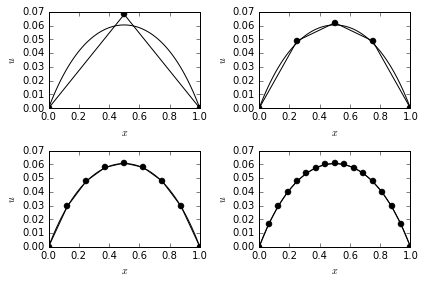

In [6]:
xx=np.linspace(0,1,100)
f=1; p=1; q=10;
uex=exact_exa2_3(xx)
for i in range(1,5):
    plt.subplot(2,2,i)
    ne=int(pow(2,i))
    uh,A,b,K,M=oned_linear_FEM(ne, p, q, f)
    plt.plot(np.linspace(0,1,ne+1),uh,'-ok')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u$')
    plt.plot(xx,uex,'-k')
plt.tight_layout() 
print('Fig 2.7')

Let's turn to two dimensions.

In [7]:
def uniform_mesh_info(ns):
    """
    A2.4 Page 69.
    """
    h=1 / ns
    x=np.linspace(0,1,ns+1);    y=np.copy(x)
    # co-ordinates of vertices
    xv,yv=np.meshgrid(x,y)
    xv=xv.ravel();    yv=yv.ravel()
    n2=ns*ns; nvtx=(ns+1)*(ns+1); ne=2*n2
    # global vertex labels of individual elements
    elt2vert=np.zeros((ne,3),dtype='int')
    vv=np.reshape(np.arange(0,nvtx),(ns + 1,ns + 1),order='F')
    v1=vv[0:ns,0:ns];  v2=vv[1:,0:ns];  v3=vv[0:ns,1:]
    elt2vert[0:n2,:]=np.vstack((v1.ravel(),
                                v2.ravel(),
                                v3.ravel())).T
    v1=vv[1:,1:]
    elt2vert[n2:,:]=np.vstack((v1.ravel(),
                               v3.ravel(),
                               v2.ravel())).T
    
    plt.axis('equal')
    plt.triplot(xv.ravel(),yv.ravel(),elt2vert, 'k-')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    return xv,yv,elt2vert,nvtx,ne,h   

def get_jac_info(xv,yv,ne,elt2vert):
    """
    A2.5 Page 74
    """        
    Jks=np.zeros((ne,2,2))
    invJks=np.zeros((ne,2,2))
    # all vertices of all elements
    x1=xv[elt2vert[:,0]]; x2=xv[elt2vert[:,1]]; x3=xv[elt2vert[:,2]]
    y1=yv[elt2vert[:,0]]; y2=yv[elt2vert[:,1]]; y3=yv[elt2vert[:,2]]
    # Jk matrices,determinants and inverses
    Jks[:,0,0]=x2 - x1; Jks[:,0,1]=y2 - y1
    Jks[:,1,0]=x3 - x1; Jks[:,1,1]=y3 - y1
    # * and / are element-wise
    detJks=Jks[:,0,0]*Jks[:,1,1]-Jks[:,0,1]*Jks[:,1,0]
    invJks[:,0,0]=(y3 - y1)/detJks
    invJks[:,0,1]=(y1 - y2)/detJks
    invJks[:,1,0]=(x1 - x3)/detJks
    invJks[:,1,1]=(x2 - x1)/detJks
    return Jks,invJks,detJks

def get_elt_arrays2D(xv,yv,invJks,detJks,ne,elt2vert,a,f):
    """
    A2.6 Page 75
    """
    bks=np.zeros((ne,3));    Aks=np.zeros((ne,3,3))
    dpsi_ds=np.array([-1,1,0]);    dpsi_dt=np.array([-1,0,1]) # for r=1
    for i in range(3):
        for j in range(3):
            grad=np.array([[dpsi_ds[i],dpsi_ds[j]],
                           [dpsi_dt[i],dpsi_dt[j]]])            
            v1=np.dot(np.squeeze([invJks[:,0,0:2]]), grad)
            v2=np.dot(np.squeeze([invJks[:,1,0:2]]), grad)
            tmp1=detJks*(np.prod(v1,1) + np.prod(v2,1))
            Aks[:,i,j]=Aks[:,i,j] + a*tmp1/ 2
        bks[:,i]=bks[:,i] + f*detJks / 6
    return Aks,bks

def twod_linear_FEM(ns,xv,yv,elt2vert,nvtx,ne,h,a,f):
    """
    A2.7 Page 76
    """
    Jks,invJks,detJks=get_jac_info(xv,yv,ne,elt2vert)
    Aks,bks=get_elt_arrays2D(xv,yv,invJks,detJks,ne,elt2vert,a,f)
    A=sparse.csc_matrix((nvtx,nvtx))
    A=np.sum(sparse.csc_matrix((Aks[:,row_no,col_no],(elt2vert[:,row_no],elt2vert[:,col_no])),
                               (nvtx,nvtx))
              for row_no in range(3)  for col_no in range(3))
    b=np.zeros(nvtx)
    for row_no in range(3):
        nrow=elt2vert[:,row_no]
        b[nrow]=b[nrow]+bks[:,row_no]
    # get discrete Dirichlet boundary data 
    b_nodes=np.squeeze(np.hstack((np.where(xv == 0),np.where(xv == 1),np.where(yv == 0),np.where(yv == 1))))
    int_nodes=np.ones(nvtx,dtype='bool');    int_nodes[b_nodes]=False;    int_nodes=np.squeeze(int_nodes)
    b_int=np.squeeze(b[int_nodes])
    wB=g_eval(xv[b_nodes],yv[b_nodes])
    # solve linear system for interior nodes;
    Ab = A[int_nodes,:];    Ab = Ab[:,b_nodes]
    rhs=b_int - Ab.dot(wB)
    A_int=A[int_nodes,:];    A_int=A_int[:,int_nodes]
    u_int=sparse.linalg.spsolve(A_int,rhs)
    # combine with boundary data and plot
    uh=np.zeros(nvtx)
    uh[int_nodes]=u_int
    uh[b_nodes]=wB
    #
    m=ns + 1
    # plotting
    ax = plt.gca(projection='3d')
    ax.plot_wireframe(xv.reshape((m,m)),
                      yv.reshape((m,m)),
                      uh.reshape((m,m)),colors='k')
   
    ax.set_zlabel(r'$u$')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    
    return u_int,A_int,rhs
    

Define a function to implement homogeneous Dirichlet boundary conditions.

In [8]:
def g_eval(x,y):
    g=np.zeros(x.shape)
    return g

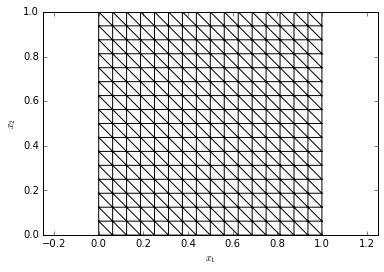

In [9]:
ns=16
xv,yv,elt2vert,nvtx,ne,h=uniform_mesh_info(ns)  # set up mesh   

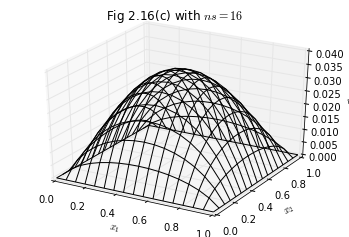

In [10]:
u_int,A_int,rhs=twod_linear_FEM(ns,xv,yv,elt2vert,nvtx, ne,h,np.ones(ne),np.ones(ne))
s=plt.title('Fig 2.16(c) with $ns=16$')

See also [FENICS](http://fenicsproject.org/) and [Firedrake](http://firedrakeproject.org/) for automated systems for constructing efficient solvers to PDEs, including the above and much more general problems, through a Python interface.